In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [2]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\u

In [3]:
ref_literature = datasets.reference_publications(taxon)

In [4]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [5]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 156 ms
Wall time: 145 ms


# BioGRID ORCS

In [22]:
orcs_results = biogrid.orcs('results')
orcs_studies = biogrid.orcs('studies')

In [23]:
orcs_studies['source_id'].value_counts()

29083409    340
30971826    325
29526696     45
27260156     33
28162770     19
           ... 
32728216      1
30898113      1
32005668      1
31353312      1
28768188      1
Name: source_id, Length: 114, dtype: int64

In [24]:
orcs_studies = orcs_studies[(orcs_studies['source_type'] == 'pubmed')]
print(len(orcs_studies['source_id'].value_counts()))
orcs_studies = orcs_studies[(orcs_studies['taxon_ncbi'] == 9606)]
print(len(orcs_studies['source_id'].value_counts()))

113
99


In [25]:
orcs_studies = orcs_studies[(orcs_studies['source_type'] == 'pubmed') & 
                            (orcs_studies['taxon_ncbi'] == 9606)]
orcs_studies['source_id'] = orcs_studies['source_id'].astype(int)
orcs_studies['pubmed_id'] = orcs_studies['source_id']
orcs_studies = orcs_studies[orcs_studies['pubmed_id'].isin(gene2pubmed['pubmed_id'])]

In [26]:
len(orcs_studies['source_id'].value_counts())

21

In [28]:
orcs_results = pd.merge(orcs_results, orcs_studies[['orcs_screen_id', 'pubmed_id']])
orcs_results = orcs_results[orcs_results['hit'] == True].copy()
orcs_results = orcs_results.drop_duplicates(['gene_ncbi', 'pubmed_id'])

In [30]:
len(orcs_results['pubmed_id'].value_counts())

21

In [8]:
orcs_results['pubmed_id'].drop_duplicates().to_csv('../data/crispr_pubmed_ids.csv', index=False)

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-20.0, 60.0)

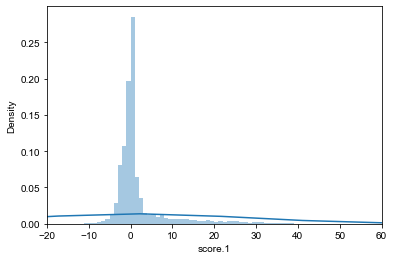

In [21]:
bins = np.arange(-20,40,1)
sns.distplot(orcs_results['score.1'], bins=bins)
plt.xlim([-20,60])

In [47]:
%%time
icite = nih.icite(dataset='citations')

CPU times: total: 21.4 s
Wall time: 25.6 s


In [63]:
def get_genes(gwas):
    # apply filters and p-value threshold here
    gwas = gwas[(gwas['pubmed_id'].isin(gene2pubmed['pubmed_id']))].copy()
    
    print(str(len(set(gwas['pubmed_id'].values))) + ' CRISPR articles')

    de_dict = gwas.groupby('pubmed_id')['gene_ncbi'].apply(set).to_dict()
    de_dict_mentioned_genes = (
        gene2pubmed[gene2pubmed['pubmed_id']
                    .isin(gwas['pubmed_id'])]
        .groupby('pubmed_id')['gene_ncbi']
        .apply(set).to_dict()
    )

    np.random.seed(49)
    n_samp = 100
    de_sets = []
    de_mentioned_sets = []
    de_mentioned_sets_null = []
    de_citations_mentioned_sets = []
    citations_mentioned_sets = []
    for comparison_key in np.unique(gwas['pubmed_id'].values):
        de_list = de_dict.get(comparison_key)

        if de_dict_mentioned_genes.get(comparison_key):
            de_list_mentioned_genes = de_dict_mentioned_genes.get(comparison_key)
        else:
            de_list_mentioned_genes = set()

        for n_n in range(n_samp):
            de_mentioned_sets_null.append(set(np.random.choice(list(de_list), 
                                                               replace=False, 
                                                               size=len(de_list_mentioned_genes & de_list))))

        de_sets.append(de_list)
        de_mentioned_sets.append(de_list_mentioned_genes)
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null)

    icite_slice = icite[icite['referenced'].isin(gwas['pubmed_id'])].copy()

    icite_slice = pd.merge(icite_slice, gene2pubmed, left_on='citing', right_on='pubmed_id')

    icite_slice = pd.merge(gwas[['gene_ncbi', 'pubmed_id']].drop_duplicates(), 
                     icite_slice, 
                     left_on='pubmed_id', right_on='referenced')

    icite_slice = icite_slice[icite_slice['gene_ncbi_x'] == icite_slice['gene_ncbi_y']]

    fig = plt.figure(figsize=(8,5))
    ax = plt.gca()
    pad = 0.2

    prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])

    de_list = set(gwas['gene_ncbi']) & prot_genes #.union(*de_sets) & prot_genes
    de_list_mentioned_genes = de_list & set(gene2pubmed[gene2pubmed['pubmed_id'].isin(gwas['pubmed_id'])]['gene_ncbi']) & prot_genes
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null) & prot_genes
    de_citations_mentioned_sets = de_list & set(icite_slice['gene_ncbi_y'])
    #itations_mentioned_sets = set().union(*citations_mentioned_sets) & prot_genes
    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')

    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes_null]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes]).fillna(0.0) + 1)[0].values, 
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_citations_mentioned_sets]).fillna(0.0) + 1)[0].values]

    ax.boxplot(data, widths=2*pad-(pad/4), positions=np.arange(len(data))+1, whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=sns.color_palette()[0], linewidth=2), 
               whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

    ax.set_xlim([1-2.5*pad, 5+2.5*pad])
    ax.set_yscale('log')
    ax.set_xticks([1,2,3,4,5], labels=['all protein-\ncoding genes',
                                     'CRISPR hits', 
                                     'null expectation',
                                   'CRISPR hits\npromoted to\ntitle/abstract', 
                                   'CRISPR hits\npromoted to\ntitle/abstract\nin citing papers'])

    df_array = []
    for gene_set, label in zip([prot_genes, 
                de_list, 
                de_list_mentioned_genes_null, 
                de_list_mentioned_genes, 
                de_citations_mentioned_sets],
                       ['genome', 
                        'hits', 
                        'mentioned_hits_null',
                        'mentioned_hits', 
                        'citations_mentioned_hits']):
        temp_df = pd.DataFrame({'gene_ncbi':list(gene_set)})
        temp_df['set'] = label
        df_array.append(temp_df)
    temp_df = pd.concat(df_array)

    temp_df.to_csv('../data/crispr_hits.csv', index=False)

21 CRISPR articles


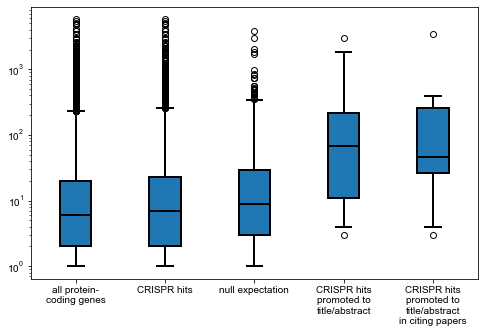

In [64]:
get_genes(orcs_results)

In [58]:
pd.read_csv('../data/crispr_hits.csv')['set'].value_counts()

genome                      19243
hits                        10064
mentioned_hits_null          1422
mentioned_hits                 27
citations_mentioned_hits       19
Name: set, dtype: int64

In [62]:
len(orcs_results['pubmed_id'].value_counts())

21